In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

data = np.load('../data.npy', allow_pickle=True)

# Shuffle dataset
np.random.seed(1337)
np.random.shuffle(data)

train, val, test = np.split(data, [int(.75*len(data)), int(.80*len(data))])

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    
# Normalize data. Pixels are [0, 255], so dividing will place them into a [0, 1] range.
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# Resize all images into a common size of 150 x 150
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [6]:
baseline = tf.keras.models.load_model('../saved_models/baseline')

2021-09-25 14:12:31.973146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 14:12:31.980978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 14:12:31.981676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 14:12:31.982509: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
attention = tf.keras.models.load_model('../saved_models/my_model')

In [8]:
b_predictions = (baseline.predict(x_test) > 0.5).astype("int32").reshape(1,-1)[0]
a_predictions = (attention.predict(x_test) > 0.5).astype("int32").reshape(1,-1)[0]

2021-09-25 14:12:34.042353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-25 14:12:34.490153: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


Text(0.5, 1.0, 'Confusion matrix for validation set')

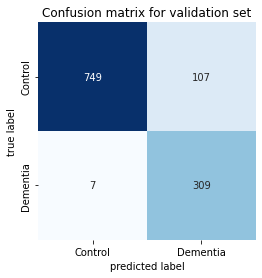

In [9]:
cm = confusion_matrix(y_test, b_predictions)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion matrix for validation set')

In [30]:
def plot_confusion_matrix(cm, classes_x, classes_y,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues): # pylint: disable=no-member
    if title is None:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes_x, yticklabels=classes_y,
           title=title,
           ylabel='True',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

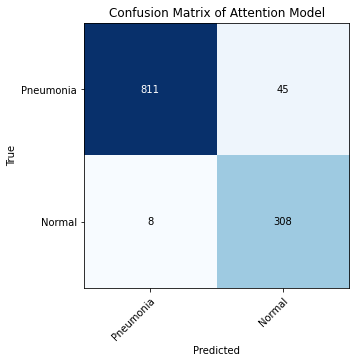

In [35]:
cnf_matrix = confusion_matrix(y_test, a_predictions)
plot_confusion_matrix(cnf_matrix, title='', classes_x=['Pneumonia', 'Normal'], 
                      classes_y=['Pneumonia', 'Normal'], normalize=False)
plt.title("Confusion Matrix of Attention Model")
plt.savefig("cmatt", bbox_inches='tight')

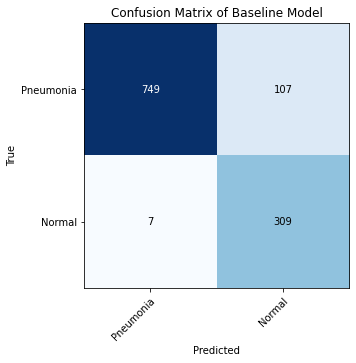

In [36]:
cnf_matrix = confusion_matrix(y_test, b_predictions)
plot_confusion_matrix(cnf_matrix, title='', classes_x=['Pneumonia', 'Normal'], 
                      classes_y=['Pneumonia', 'Normal'], normalize=False)
plt.title("Confusion Matrix of Baseline Model")
plt.savefig("cmbas", bbox_inches='tight')

In [6]:
different = np.nonzero(b_predictions != a_predictions)[0]
different

array([   6,   39,   44,   55,   65,   76,   96,  105,  112,  131,  139,
        217,  278,  286,  288,  293,  326,  380,  385,  391,  424,  432,
        438,  463,  470,  474,  482,  486,  495,  496,  557,  592,  609,
        620,  641,  646,  647,  662,  684,  732,  734,  736,  745,  748,
        767,  787,  798,  821,  877,  881,  890,  895,  910,  925,  940,
        941,  952,  966,  969,  980,  982, 1012, 1037, 1063, 1091, 1096,
       1105, 1110, 1117, 1127, 1131, 1146, 1147])

In [7]:
different.shape

(73,)

In [8]:
73/len(y_test)

0.06228668941979522

In [9]:
y_test[different]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [10]:
np.sum(a_predictions[different] == y_test[different])

67

In [11]:
np.sum(b_predictions[different] == y_test[different])

6

In [12]:
from utils.vizgradcam.gradcam import VizGradCAM

0
0
0
0
0
0


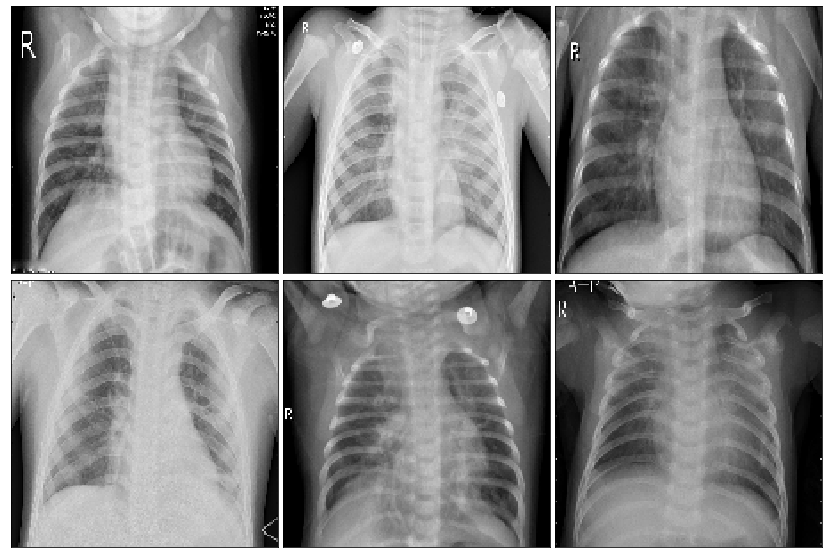

In [13]:
i = 0
sample = np.random.choice(different, size=20)
fig, ax = plt.subplots(2, 3, figsize=(12, 8.2))
plt.tight_layout()
for item in sample:
    if i >= 6:
        break
    if a_predictions[item] == y_test[item] and b_predictions[item] != y_test[item]:
        ax[i//3, i%3].set_xticks([])
        ax[i//3, i%3].set_yticks([])
#         img = VizGradCAM(attention, x_test[item], plot_results=False, return_scan=True)
        img = x_test[item].reshape(150, 150)
        ax[i//3, i%3].imshow(img, cmap="gray", interpolation='none')
        i += 1
        print(y_test[item])

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.savefig('attention_good_baseline_bad')

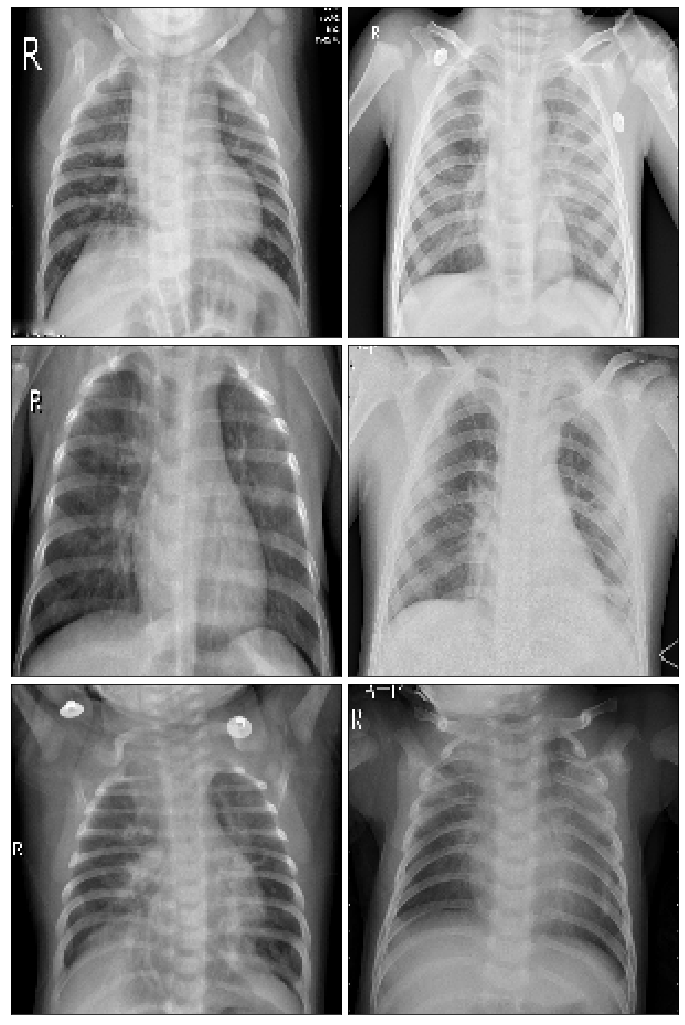

In [14]:
i = 0
fig, ax = plt.subplots(3, 2, figsize=(10, 14.7))
plt.tight_layout()
for item in sample:
    if i >= 6:
        break
    if a_predictions[item] == y_test[item] and b_predictions[item] != y_test[item]:
        ax[i//2, i%2].set_xticks([])
        ax[i//2, i%2].set_yticks([])
#         img = VizGradCAM(baseline, x_test[item], plot_results=False, return_scan=True)
        img = x_test[item].reshape(150, 150)
        ax[i//2, i%2].imshow(img, cmap="gray", interpolation='none')
        i += 1

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.savefig('attention_good_baseline_bad')

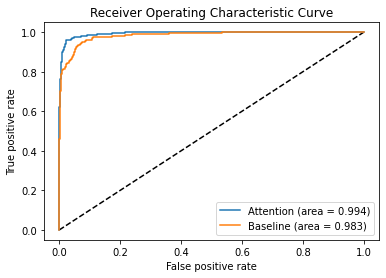

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_attention = attention.predict(x_test).ravel()
fpr_attention, tpr_attention, thresholds_attention = roc_curve(y_test, y_pred_attention)
auc_attention = auc(fpr_attention, tpr_attention)

y_pred_baseline = baseline.predict(x_test).ravel()
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(y_test, y_pred_baseline)
auc_baseline = auc(fpr_baseline, tpr_baseline)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_attention, tpr_attention, label='Attention (area = {:.3f})'.format(auc_attention))
plt.plot(fpr_baseline, tpr_baseline, label='Baseline (area = {:.3f})'.format(auc_baseline))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='best')
plt.savefig("auroc")
plt.show()

In [43]:
from tqdm.notebook import tqdm

In [ ]:
for idx, img in tqdm(enumerate(x_test), total=len(x_test)):    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle(f'ID: {idx}, class: {y_test[idx]}')
    img = x_test[idx]
    gradcambase = VizGradCAM(baseline, img, plot_results=False, return_scan=True)
    ax[0].imshow(gradcambase)
    ax[0].set_title('baseline')
    gradcamatt = VizGradCAM(attention, img, plot_results=False, return_scan=True)
    ax[1].imshow(gradcamatt)
    ax[1].set_title('attention')
    plt.savefig(f'images/{idx}.png')